# Image Captioning project

In [1]:
import os  
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import json
import spacy  
from PIL import Image
from random import shuffle
from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence  

from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms

import torch.optim as optim
import torchvision.models as models
# import torchvision.transforms as T

IMG_SHAPE=(224, 224)

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Data loading

The dataset that we are using is the Viz Wiz dataset.
The original dataset contains 39,181 images with 5 captions for each one of these 
images.

Our aim is to develop a model that, given an image, returns a sentence that describes
it.

The original train dataset is too large (23,431 images). We chose to perform training on the original validation dataset (7,750 images). As the original test dataset captions are not publicly shared, we chose to perform testing on a subset of training set (1171 images). 

In [3]:
#importing original validation dataset for train task
!wget http://ivc.ischool.utexas.edu/VizWiz_final/images/val.zip

--2022-03-28 16:51:51--  http://ivc.ischool.utexas.edu/VizWiz_final/images/val.zip
Resolving ivc.ischool.utexas.edu (ivc.ischool.utexas.edu)... 146.6.168.124
Connecting to ivc.ischool.utexas.edu (ivc.ischool.utexas.edu)|146.6.168.124|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://ivc.ischool.utexas.edu/VizWiz_final/images/val.zip [following]
--2022-03-28 16:51:52--  https://ivc.ischool.utexas.edu/VizWiz_final/images/val.zip
Connecting to ivc.ischool.utexas.edu (ivc.ischool.utexas.edu)|146.6.168.124|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3488913457 (3.2G) [application/zip]
Saving to: ‘val.zip’

val.zip             100%[===================>]   3.25G  17.9MB/s    in 3m 7s   

2022-03-28 16:55:00 (17.8 MB/s) - ‘val.zip’ saved [3488913457/3488913457]



In [4]:
#importing original training dataset for train task
!wget https://ivc.ischool.utexas.edu/VizWiz_final/images/train.zip

--2022-03-28 16:55:00--  https://ivc.ischool.utexas.edu/VizWiz_final/images/train.zip
Resolving ivc.ischool.utexas.edu (ivc.ischool.utexas.edu)... 146.6.168.124
Connecting to ivc.ischool.utexas.edu (ivc.ischool.utexas.edu)|146.6.168.124|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11298421598 (11G) [application/zip]
Saving to: ‘train.zip’

train.zip           100%[===================>]  10.52G  17.8MB/s    in 10m 6s  

2022-03-28 17:05:07 (17.8 MB/s) - ‘train.zip’ saved [11298421598/11298421598]



In [5]:
#importing captions
!wget http://ivc.ischool.utexas.edu/VizWiz_final/caption/annotations.zip

--2022-03-28 17:05:07--  http://ivc.ischool.utexas.edu/VizWiz_final/caption/annotations.zip
Resolving ivc.ischool.utexas.edu (ivc.ischool.utexas.edu)... 146.6.168.124
Connecting to ivc.ischool.utexas.edu (ivc.ischool.utexas.edu)|146.6.168.124|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://ivc.ischool.utexas.edu/VizWiz_final/caption/annotations.zip [following]
--2022-03-28 17:05:08--  https://ivc.ischool.utexas.edu/VizWiz_final/caption/annotations.zip
Connecting to ivc.ischool.utexas.edu (ivc.ischool.utexas.edu)|146.6.168.124|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4509069 (4.3M) [application/zip]
Saving to: ‘annotations.zip’

annotations.zip     100%[===================>]   4.30M  3.34MB/s    in 1.3s    

2022-03-28 17:05:10 (3.34 MB/s) - ‘annotations.zip’ saved [4509069/4509069]



In [6]:
!ls

annotations.zip			sample_data  val.zip
attention_model_state_ep80.pth	train.zip


In [23]:
#uncomment this line to unzip original validation dataset 
# !unzip  val.zip -d /data/
# !rm val.zip

In [8]:
#unziping original validation dataset captions
!unzip annotations.zip -d /captions
# !rm annotations.zip

Archive:  annotations.zip
   creating: /captions/annotations/
  inflating: /captions/annotations/test.json  
  inflating: /captions/annotations/val.json  
  inflating: /captions/annotations/train.json  


In [24]:
#uncomment this line to unzip original training dataset 

# !unzip  train.zip -d /data

In [10]:
dataset = json.load(open('/captions/annotations/val.json', 'r'))
images_df = pd.DataFrame(dataset['images'])
images_df = images_df[images_df['text_detected']==True]

In [11]:
annotations_df = pd.DataFrame(dataset['annotations'])
annotations_df = annotations_df[annotations_df['is_precanned']==False]
annotations_df = annotations_df[annotations_df['is_rejected']==False]
annotations_df = annotations_df[annotations_df['text_detected']==True]

In [12]:
merged_df = pd.merge(images_df, annotations_df, left_on='id', right_on='image_id', how='inner')
merged_df = merged_df[['file_name', 'image_id', 'caption']]
merged_df.head(3)

,file_name,image_id,caption
0,VizWiz_val_00000000.jpg,23431,A computer screen shows a repair prompt on the...
1,VizWiz_val_00000000.jpg,23431,a computer screen with a repair automatically ...
2,VizWiz_val_00000000.jpg,23431,partial computer screen showing the need of re...


In [13]:
img_path = '/data/val/'
def show_img_caption(df, id):
  fig = plt.figure()
  captions = df[df['image_id']==id]
  file_name = captions['file_name'].reset_index(drop=True).iloc[0]
  im = Image.open(img_path + file_name).convert("RGB")
  plt.imshow(im)
  fig.text(.1,-.3, '\n\n '.join(captions['caption'].apply(lambda s: '-' + s).values))
  plt.show()

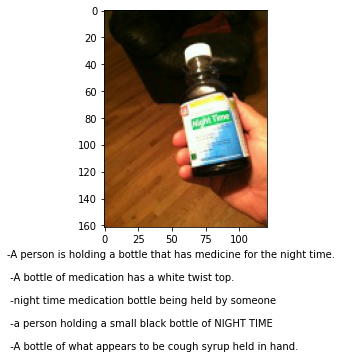

In [14]:
show_img_caption(merged_df, 23432)

## Defining Vocabulary class

In [15]:
# We will use the English spacy tokenizer
spacy_eng = spacy.load("en")

Below, we define a vocabulary class. It will be constructed using the captions corpus of our training dataset. We construct two dictionnaries to go from words to numerical values and vice versa. 

As text preprocessing, for the moment, we only put all the words to lowercase. We could also apply other preprocessing and cleaning techniques such as lemmatization, stemming, removing the non-alphanumeric characters etc.

Moreover, when building the vocabulary, we only keep the most frequent words in the corpus using a frequency threshold.




In [16]:
class Vocabulary:
    def __init__(self, freq_thresh=5):
        self.i2w = {}
        self.w2i = {}
        self.freq_thresh = freq_thresh

    def __len__(self):
        return len(self.i2w)

    @staticmethod
    def tokenizer_eng(text):
        return [tok.text.lower() for tok in spacy_eng.tokenizer(text)]

    def build_vocabulary(self, caption_list):
        freq_dict = {}
        idx = 4

        for sentence in caption_list:
            for word in self.tokenizer_eng(sentence):
                if word not in freq_dict:
                    freq_dict[word] = 1

                else:
                    freq_dict[word] += 1

        filtered_words = {k:v for k,v in freq_dict.items() if v >= self.freq_thresh}
        self.w2i = {k: i+idx for i,k in enumerate(filtered_words.keys())}
        self.i2w = {v:k for k,v in self.w2i.items()}
        self.i2w.update({0: "<PAD>", 1: "<SOS>", 2: "<EOS>", 3: "<UNK>"})
        self.w2i.update({"<PAD>": 0, "<SOS>": 1, "<EOS>": 2, "<UNK>": 3})
                

    def numericalize(self, caption):
        # convert a text into an index list

        token_cap = self.tokenizer_eng(caption)
        return [self.w2i[word] if word in self.w2i else self.w2i["<UNK>"] for word in token_cap]


## Defining the Vizwiz Dataset class

Here we define a custom dataset which will make data loading and training more convenient.

In [17]:
class VizwizDataset(Dataset):
    def __init__(self, 
                 merged_df,
                 img_path='/data/val/' ,
                 transform=None, freq_thresh=5):

        self.img_path = img_path
        self.df = merged_df
        self.transform = transform


        # Initialize vocabulary and build vocab
        self.vocab = Vocabulary(freq_thresh)
        self.vocab.build_vocabulary(self.df.caption.values)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        # returns an element from the dataset, an element is 
        #a tuple: an image (after transformation) and the corresponding caption (indices)

        caption = self.df["caption"].iloc[index]
        img_file = self.df["file_name"].iloc[index]
       
        img = Image.open(os.path.join(self.img_path, img_file)).convert("RGB")
        if self.transform is not None:
            img = self.transform(img)

        numericalized_caption = [self.vocab.w2i["<SOS>"]]
        numericalized_caption += self.vocab.numericalize(caption)
        numericalized_caption.append(self.vocab.w2i["<EOS>"])

        return img, torch.tensor(numericalized_caption)

## Defining pad batch class and the dataloader


In [18]:
class pad_batch():

    # This will be used by the dataloader to pad captions per batch
    def __init__(self, pad_idx):
        self.pad_idx = pad_idx

    def __call__(self, batch):
        imgs = [item[0].unsqueeze(0) for item in batch]
        imgs = torch.cat(imgs, dim=0)
        targets = [item[1] for item in batch]
        targets = pad_sequence(targets, batch_first=True, padding_value=self.pad_idx)

        return imgs, targets

In [19]:
# Here we define some transformations to be applied on the training images
# Random cropping is a data augmentation technique that can help our model generalize better

transform = transforms.Compose(
        [
            transforms.Resize((356, 356)),
            transforms.RandomCrop(IMG_SHAPE),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ]
    )



vizdataset = VizwizDataset(merged_df, transform=transform)

# The dataloader bellow will allow us to create batches for training
# the shuffle parameter allows us to mix the data at each time to reduce overfitting
data_loader = DataLoader(dataset=vizdataset,
                    batch_size=64,
                    num_workers=2,
                    shuffle=True,
                    collate_fn=pad_batch(pad_idx=vizdataset.vocab.w2i["<PAD>"]),
    )

## The Model Architecture

Our captioning Model is Seq2Seq model. The **Encoder** uses a pretrained CNN (ResNet model) to extract the features. The **Decoder**, is composed of **LSTM** and also uses attention mechanism between the feature maps produced by the encoder and the decoder hidden states. More specifically, we used an implementation of the Bahdanau Attention Decoder.
The implementation bellow uses parts of this project: https://github.com/MakarovArtyom/Image-Captioning-with-Attention

### Encoder

The encoder takes as input an 224x224 image and produces 49 feature maps, each one of size 2048.

In [20]:
class EncoderCNN(nn.Module):
    def __init__(self):
        super(EncoderCNN, self).__init__()
        resnet = models.resnet50(pretrained=True)
        for param in resnet.parameters():
            param.requires_grad_(False)
        
        modules = list(resnet.children())[:-2]
        self.resnet = nn.Sequential(*modules)
        

    def forward(self, images):
        features = self.resnet(images)                                    #(batch_size,2048,7,7)
        features = features.permute(0, 2, 3, 1)                           #(batch_size,7,7,2048)
        features = features.view(features.size(0), -1, features.size(-1)) #(batch_size,49,2048)
        return features

Bahdanau Attention block. 
- The forward method of this layer takes as input the encoder feature maps as well as the current decoder hidden state and returns the attention weights and the produced context vector.

In [21]:
class Attention(nn.Module):

    def __init__(self, encoder_dim,decoder_dim,attention_dim):
        super(Attention, self).__init__()
        
        self.attention_dim = attention_dim
        
        self.W = nn.Linear(decoder_dim,attention_dim)
        self.U = nn.Linear(encoder_dim,attention_dim)
        
        self.A = nn.Linear(attention_dim,1)
        
        
        
        
    def forward(self, features, hidden_state):
        u_hs = self.U(features)     #(batch_size,num_layers,attention_dim)
        w_ah = self.W(hidden_state) #(batch_size,attention_dim)
        
        combined_states = torch.tanh(u_hs + w_ah.unsqueeze(1)) #(batch_size,num_layers,attemtion_dim)
        
        attention_scores = self.A(combined_states)         #(batch_size,num_layers,1)
        attention_scores = attention_scores.squeeze(2)     #(batch_size,num_layers)
        
        
        alpha = F.softmax(attention_scores,dim=1)          #(batch_size,num_layers)
        
        attention_weights = features * alpha.unsqueeze(2)  #(batch_size,num_layers,features_dim)
        attention_weights = attention_weights.sum(dim=1)   #(batch_size,num_layers)
        
        return alpha,attention_weights

### Decoder

The decoder has an LSTM-based architecture enriched with attention mechanism. At each decoding step, the decoder receives a context vector resulting from the interaction between its current hidden state and all the encoder hidden states. To initialize the LSTM hidden state and cell memory, we average the encoder feature maps.

In [22]:
class DecoderRNN(nn.Module):
    def __init__(self,embed_size, vocab_size, attention_dim,encoder_dim,decoder_dim,drop_prob=0.3):
        super().__init__()
        
        #save the model param
        self.vocab_size = vocab_size
        self.attention_dim = attention_dim
        self.decoder_dim = decoder_dim
        
        self.embedding = nn.Embedding(vocab_size,embed_size)
        self.attention = Attention(encoder_dim,decoder_dim,attention_dim)
        
        
        self.init_h = nn.Linear(encoder_dim, decoder_dim)  
        self.init_c = nn.Linear(encoder_dim, decoder_dim)  
        self.lstm_cell = nn.LSTMCell(embed_size+encoder_dim,decoder_dim,bias=True)
        self.f_beta = nn.Linear(decoder_dim, encoder_dim)
        
        
        self.fcn = nn.Linear(decoder_dim,vocab_size)
        self.drop = nn.Dropout(drop_prob)
        
        
    def init_hidden_state(self, encoder_out):
        mean_encoder_out = encoder_out.mean(dim=1)
        h = self.init_h(mean_encoder_out)  # (batch_size, decoder_dim)
        c = self.init_c(mean_encoder_out)
        return h, c    
    
    def forward(self, features, captions):
        
        #vectorize the caption
        embeds = self.embedding(captions)
        
        # Initialize LSTM state
        h, c = self.init_hidden_state(features)  # (batch_size, decoder_dim)
        
        #get the seq length to iterate
        seq_length = len(captions[0])-1 #Exclude the last one
        batch_size = captions.size(0)
        num_features = features.size(1)
        
        preds = torch.zeros(batch_size, seq_length, self.vocab_size).to(device)
        alphas = torch.zeros(batch_size, seq_length,num_features).to(device)
                
        for s in range(seq_length):
            alpha,context = self.attention(features, h)
            lstm_input = torch.cat((embeds[:, s], context), dim=1)
            h, c = self.lstm_cell(lstm_input, (h, c))
                    
            output = self.fcn(self.drop(h))
            
            preds[:,s] = output
            alphas[:,s] = alpha  
        
        
        return preds, alphas
    
    def generate_caption(self,features,max_len=20,vocab=None):
        '''
        Inference part
        Given the image features generate the captions

        '''
        
        batch_size = features.size(0)
        h, c = self.init_hidden_state(features)  # (batch_size, decoder_dim)
        
        alphas = []
        
        #starting input
        word = torch.tensor(vocab.w2i['<SOS>']).view(1,-1).to(device)
        embeds = self.embedding(word)

        
        captions = []
        
        for i in range(max_len):
            alpha,context = self.attention(features, h)
            
            
            #store the apla score
            alphas.append(alpha.cpu().detach().numpy())
            
            lstm_input = torch.cat((embeds[:, 0], context), dim=1)
            h, c = self.lstm_cell(lstm_input, (h, c))
            output = self.fcn(self.drop(h))
            output = output.view(batch_size,-1)
        
            
            #select the word with most val
            predicted_word_idx = output.argmax(dim=1)
            
            #save the generated word
            captions.append(predicted_word_idx.item())
            
            #end if <EOS detected>
            if vocab.i2w[predicted_word_idx.item()] == "<EOS>":
                break
            
            #send generated word as the next caption
            embeds = self.embedding(predicted_word_idx.unsqueeze(0))
        
        #covert the vocab idx to words and return sentence
        return [vocab.i2w[idx] for idx in captions],alphas
    



### Whole Architecture: Encoder + Decoder

Finally, we put all the previous blocks together to build our final model.

In [25]:
class EncoderDecoder(nn.Module):
    def __init__(self,embed_size, vocab_size, attention_dim,encoder_dim,decoder_dim,drop_prob=0.3):
        super().__init__()
        self.encoder = EncoderCNN()
        self.decoder = DecoderRNN(
            embed_size=embed_size,
            vocab_size = len(vizdataset.vocab),
            attention_dim=attention_dim,
            encoder_dim=encoder_dim,
            decoder_dim=decoder_dim
        )
        
    def forward(self, images, captions):
        features = self.encoder(images)
        outputs = self.decoder(features, captions)
        return outputs


## Model

In [26]:
#Defining the Hyperparameters
embed_size=300
vocab_size = len(vizdataset.vocab)
attention_dim=256
encoder_dim=2048
decoder_dim=512
learning_rate = 3e-4


In [27]:
#init model
model = EncoderDecoder(
    embed_size=embed_size,
    vocab_size = vocab_size,
    attention_dim=attention_dim,
    encoder_dim=encoder_dim,
    decoder_dim=decoder_dim
).to(device)

torch.save(model.state_dict(),f'attention_model_state_ep{0}.pth')

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [28]:
# Defining the loss and the optimizer
criterion = nn.CrossEntropyLoss(ignore_index=vizdataset.vocab.w2i["<PAD>"])
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

## Training or loading pretrained model

You can choose whether to load a trained model weights or train a new model. We saved 3 training checkpoints which we made available here: https://drive.google.com/drive/folders/1cpSWwWRYtvuLwaElMz5EwepsBygWkdev

In [29]:
!ls

annotations.zip		       attention_model_state_ep80.pth  train.zip
attention_model_state_ep0.pth  sample_data


In [30]:
## Loading previous model weights: uncomment the next line

model.load_state_dict(torch.load('attention_model_state_ep80.pth'))

<All keys matched successfully>

In [ ]:
def show_image(img, title=None):
    """Imshow for Tensor."""
    
    #unnormalize 
    img[0] = img[0] * 0.229
    img[1] = img[1] * 0.224 
    img[2] = img[2] * 0.225 
    img[0] += 0.485 
    img[1] += 0.456 
    img[2] += 0.406
    
    img = img.numpy().transpose((1, 2, 0))
    
    
    plt.imshow(img)
    if title is not None:
        plt.title(title)
    plt.show()

=======> epoch1


  6%|▌         | 19/342 [00:51<14:47,  2.75s/it]

Epoch: 1 loss: 0.85023


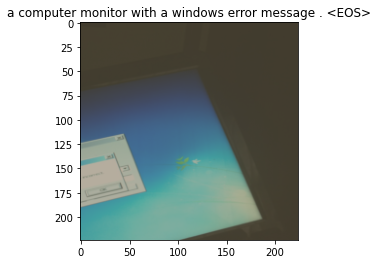

 11%|█▏        | 39/342 [01:51<14:03,  2.78s/it]

Epoch: 1 loss: 1.17810


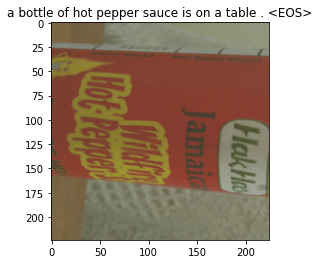

 17%|█▋        | 59/342 [02:53<12:48,  2.71s/it]

Epoch: 1 loss: 1.30328


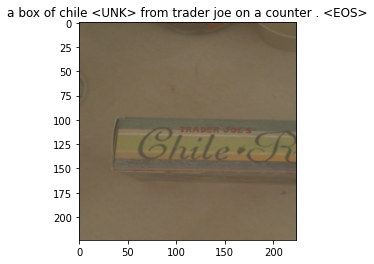

 23%|██▎       | 79/342 [03:53<11:33,  2.64s/it]

Epoch: 1 loss: 1.24774


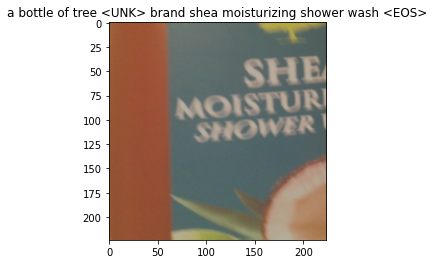

 29%|██▉       | 99/342 [04:56<11:15,  2.78s/it]

Epoch: 1 loss: 1.26753


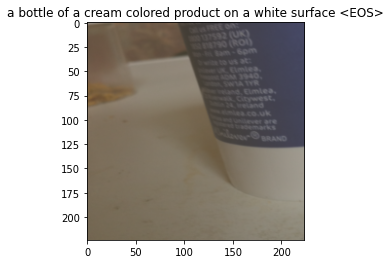

 35%|███▍      | 119/342 [05:53<09:40,  2.60s/it]

Epoch: 1 loss: 1.29742


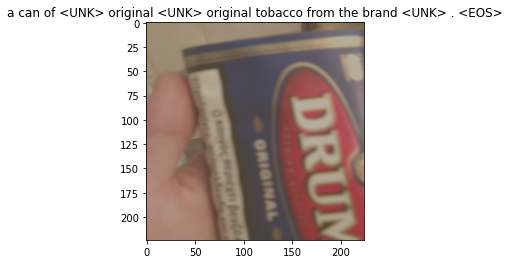

 41%|████      | 139/342 [06:51<09:03,  2.68s/it]

Epoch: 1 loss: 1.25345


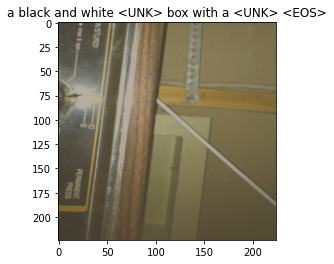

 46%|████▋     | 159/342 [07:50<07:39,  2.51s/it]

Epoch: 1 loss: 1.24203


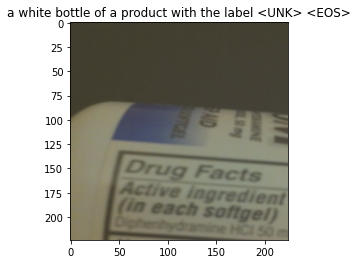

 52%|█████▏    | 179/342 [08:48<07:09,  2.64s/it]

Epoch: 1 loss: 1.25748


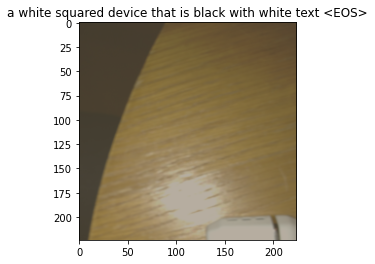

 58%|█████▊    | 199/342 [09:46<06:42,  2.81s/it]

Epoch: 1 loss: 1.13440


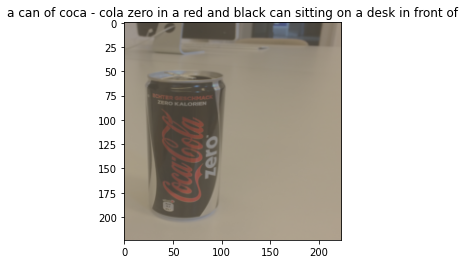

 64%|██████▍   | 219/342 [10:47<05:47,  2.82s/it]

Epoch: 1 loss: 1.32055


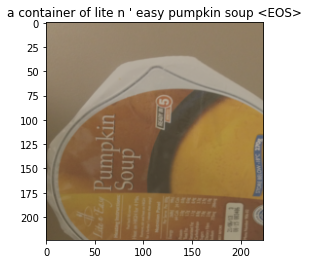

 70%|██████▉   | 239/342 [11:45<04:27,  2.59s/it]

Epoch: 1 loss: 1.17926


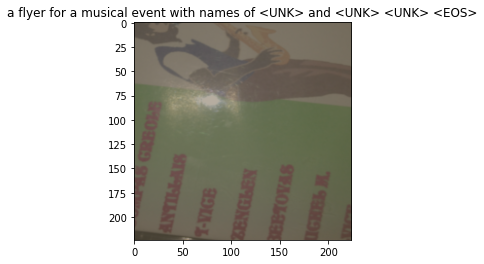

 76%|███████▌  | 259/342 [12:43<03:14,  2.35s/it]

Epoch: 1 loss: 1.26763


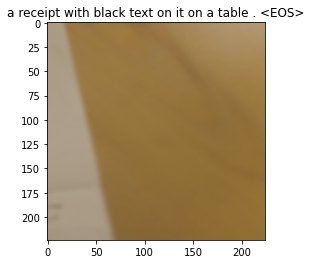

 82%|████████▏ | 279/342 [13:41<02:51,  2.72s/it]

Epoch: 1 loss: 1.31326


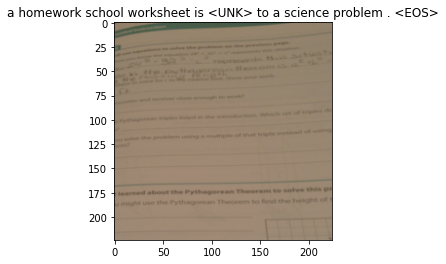

 87%|████████▋ | 299/342 [14:43<01:58,  2.75s/it]

Epoch: 1 loss: 1.18793


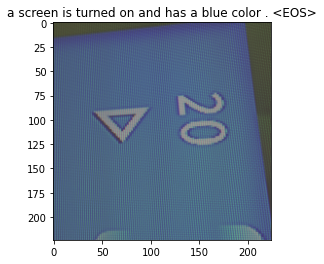

 93%|█████████▎| 319/342 [15:41<01:00,  2.63s/it]

Epoch: 1 loss: 1.24011


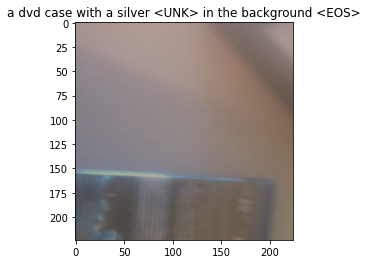

 99%|█████████▉| 339/342 [16:40<00:08,  2.67s/it]

Epoch: 1 loss: 1.31885


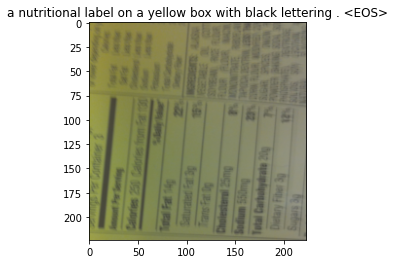

CPU times: user 2min 36s, sys: 22.6 s, total: 2min 58s
Wall time: 16min 51s


In [ ]:
%%time

num_epochs = 1
print_every = 20
save_every = 1

for epoch in range(1,num_epochs+1): 
    print(f'=======> epoch{epoch}')
    for idx, (image, captions) in tqdm(enumerate(iter(data_loader)), total=len(data_loader), leave=False):
        image,captions = image.to(device),captions.to(device)

        # Zero the gradients.
        optimizer.zero_grad()

        # Forward pass
        outputs,attentions = model(image, captions)

        # Calculate the batch loss.
        targets = captions[:,1:]
        loss = criterion(outputs.view(-1, vocab_size), targets.reshape(-1))
        
        # Backward pass.
        loss.backward()

        # Update the parameters in the optimizer.
        optimizer.step()

        if (idx+1)%print_every == 0:
            print("Epoch: {} loss: {:.5f}".format(epoch,loss.item()))
            
            
            #generate the caption
            model.eval()
            with torch.no_grad():
                dataiter = iter(data_loader)
                img,_ = next(dataiter)
                features = model.encoder(img[0:1].to(device))
                caps,alphas = model.decoder.generate_caption(features,vocab=vizdataset.vocab)
                caption = ' '.join(caps)
                show_image(img[0],title=caption)
                
            model.train()

        #save the  model
    if epoch % save_every == 0:
        torch.save(model.state_dict(),f'attention_model_state_ep{epoch}.pth')

## Visualizing the attention weights
Defining helper functions
<li>Given the image generate captions and attention scores</li>
<li>Plot the attention scores in the image</li>

In [38]:
#generate caption
def get_caps_from(features_tensors, show=True):
    #generate the caption
    model.eval()
    with torch.no_grad():
        features = model.encoder(features_tensors.to(device))
        caps,alphas = model.decoder.generate_caption(features,vocab=vizdataset.vocab)
        caption = ' '.join(caps)
        if show:
            show_image(features_tensors[0],title=caption)
            
    
    return caps,alphas

#Show attention
def plot_attention(img, result, attention_plot):
    #untransform
    img[0] = img[0] * 0.229
    img[1] = img[1] * 0.224 
    img[2] = img[2] * 0.225 
    img[0] += 0.485 
    img[1] += 0.456 
    img[2] += 0.406
    
    img = img.numpy().transpose((1, 2, 0))
    temp_image = img

    fig = plt.figure(figsize=(15, 15))

    len_result = len(result)
    for l in range(len_result):
        temp_att = attention_plot[l].reshape(7,7)
        
        ax = fig.add_subplot(len_result//2,len_result//2, l+1)
        ax.set_title(result[l])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.7, extent=img.get_extent())
        

    plt.tight_layout()
    plt.show()

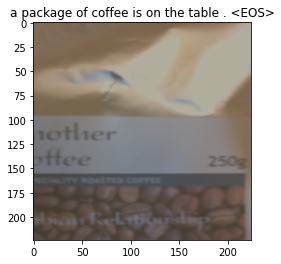

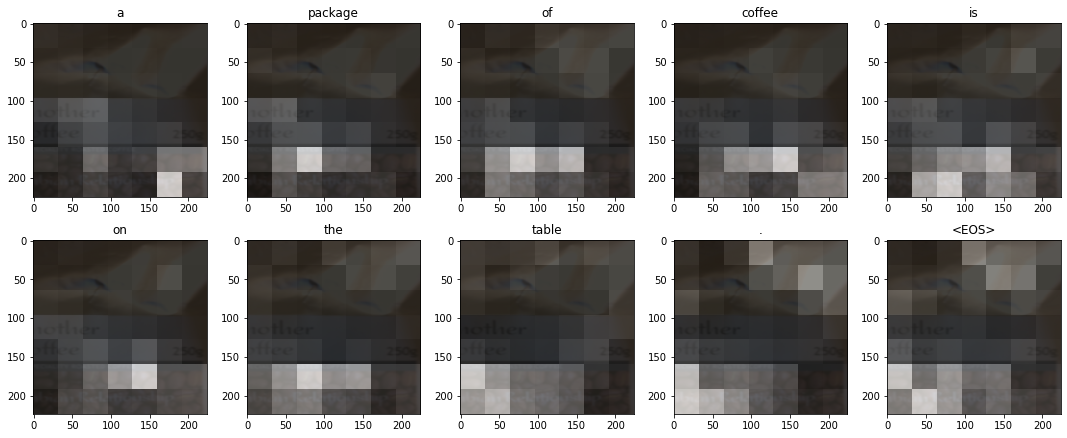

In [ ]:
dataiter = iter(data_loader)
images,_ = next(dataiter)

img = images[0].detach().clone()
img1 = images[0].detach().clone()
caps,alphas = get_caps_from(img.unsqueeze(0))

plot_attention(img1, caps, alphas)

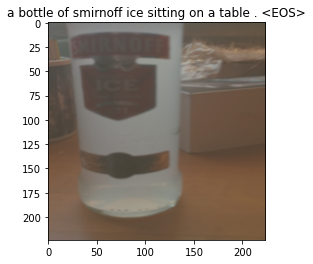

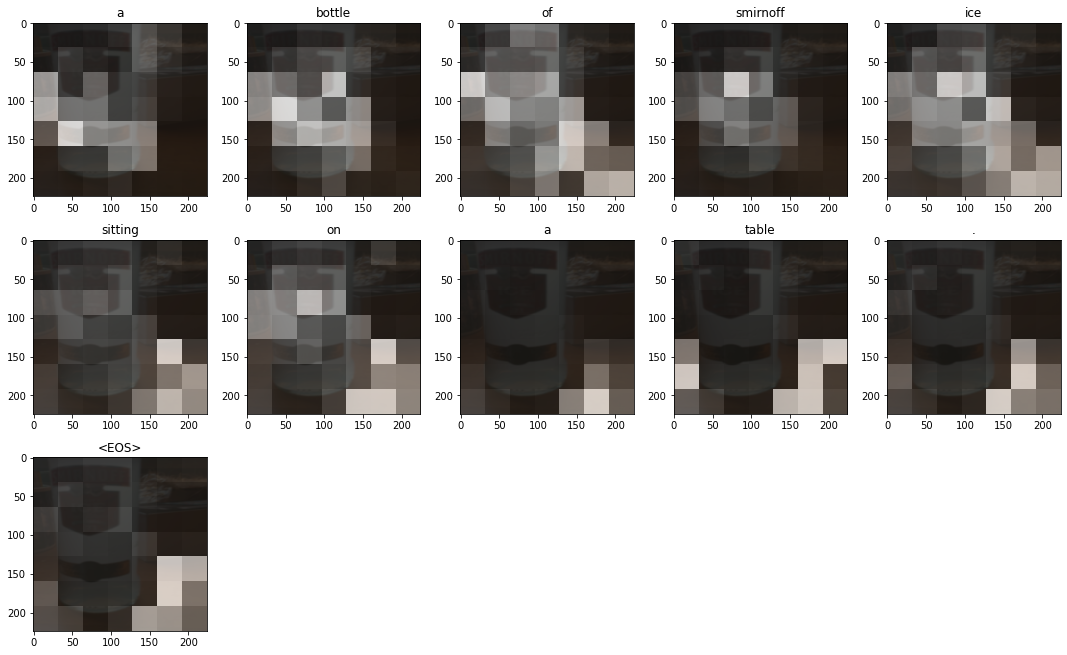

In [ ]:
dataiter = iter(data_loader)
images,_ = next(dataiter)

img = images[0].detach().clone()
img1 = images[0].detach().clone()
caps,alphas = get_caps_from(img.unsqueeze(0))

plot_attention(img1, caps, alphas)

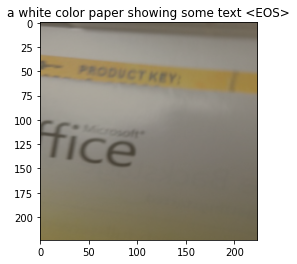

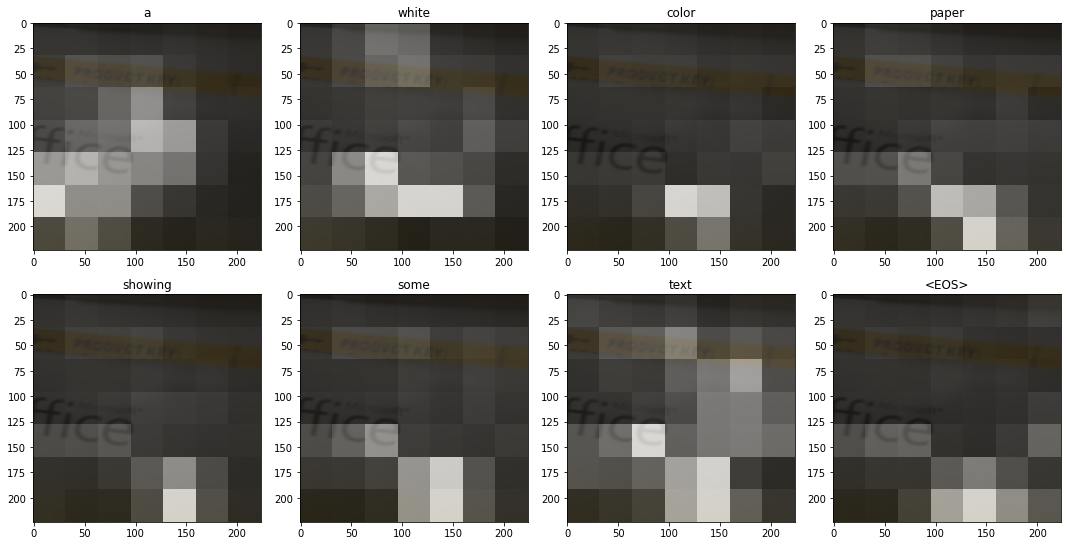

In [ ]:
dataiter = iter(data_loader)
images,_ = next(dataiter)

img = images[0].detach().clone()
img1 = images[0].detach().clone()
caps,alphas = get_caps_from(img.unsqueeze(0))

plot_attention(img1, caps, alphas)

## Testing on new images

Since we trained on the Vizwiz validation set, we will use a subset from the Vizwiz training set as a test set to evaluate our model performance.

In [31]:
dataset_train = json.load(open('/captions/annotations/train.json', 'r'))
images_df_train = pd.DataFrame(dataset_train['images'])
images_df_train = images_df_train[images_df_train['text_detected']==True]

In [32]:
annotations_df_train = pd.DataFrame(dataset_train['annotations'])
annotations_df_train = annotations_df_train[annotations_df_train['is_precanned']==False]
annotations_df_train = annotations_df_train[annotations_df_train['is_rejected']==False]
annotations_df_train = annotations_df_train[annotations_df_train['text_detected']==True]

In [33]:
merged_df_train = pd.merge(images_df_train, annotations_df_train, left_on='id', right_on='image_id', how='inner')
merged_df_train = merged_df_train[['file_name', 'image_id', 'caption']]

In [88]:
# We take a subset for test
import random
random.seed(0)
imgs_list_train = merged_df_train['file_name'].unique()
random.shuffle(imgs_list_train)
img_subset_test = imgs_list_train[:int(0.05 * len(imgs_list_train))]
merged_subset_test = merged_df_train[merged_df_train['file_name'].isin(img_subset_test)]
print(merged_subset_test.shape)

(3197, 3)


In [35]:
transform_test = transforms.Compose(
        [
            transforms.Resize(IMG_SHAPE),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ]
    )

In [36]:
# We use the nltk implementation if the blue score
# in order to evaluate the predictions quality
from nltk.translate import bleu_score

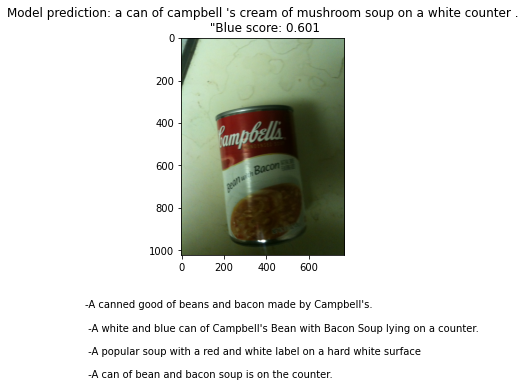

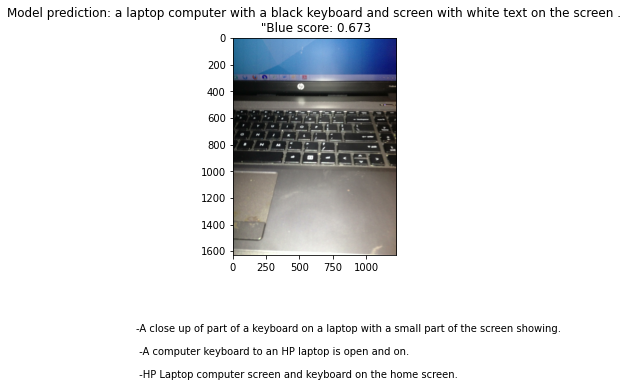

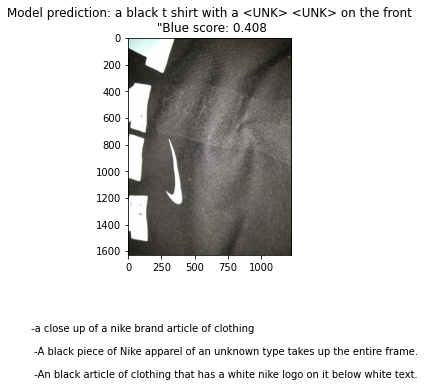

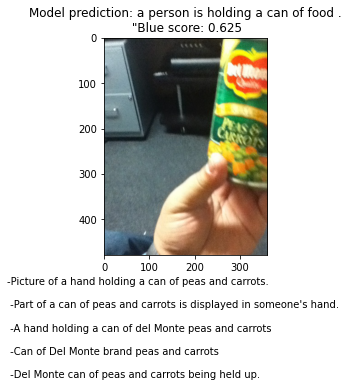

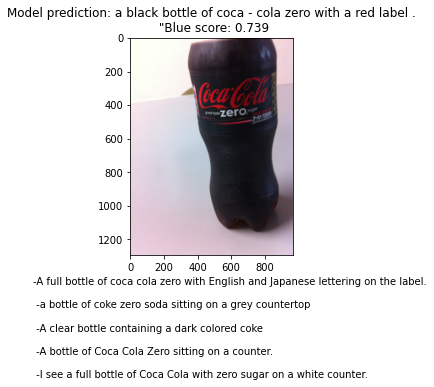

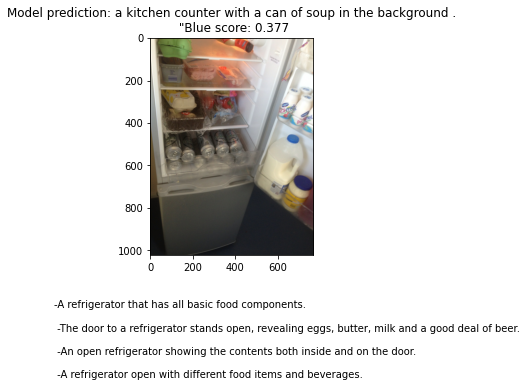

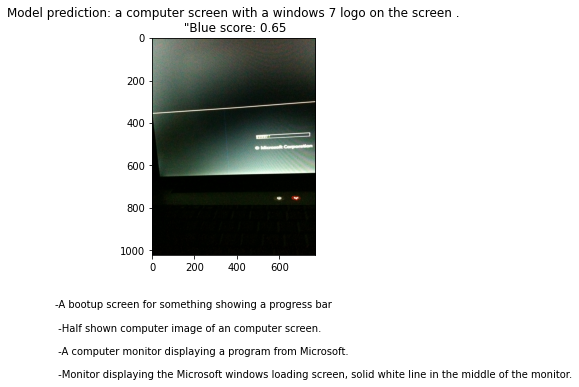

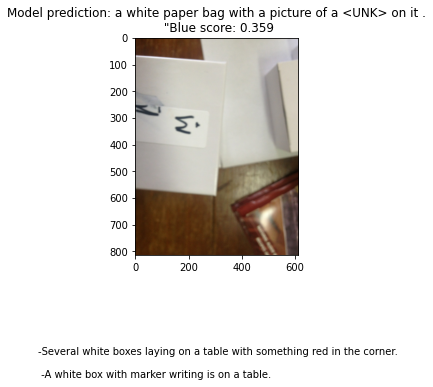

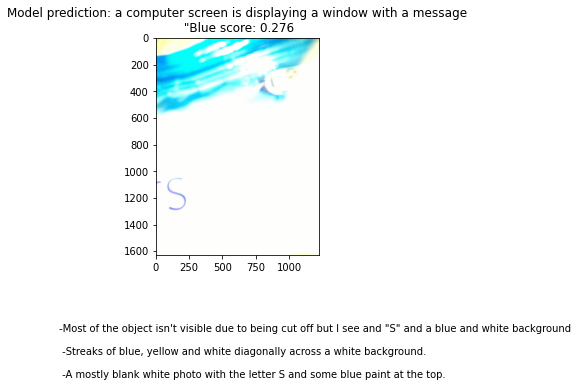

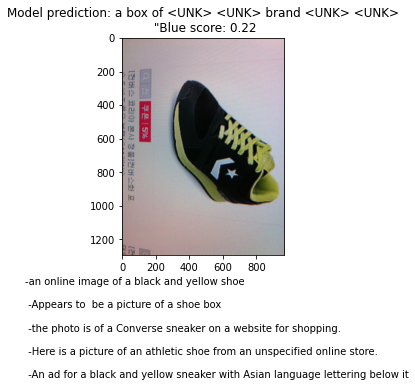

In [98]:
def show_prediction(img_path='/data/train/', df=merged_subset_test):
    fig = plt.figure()
    random_image = np.random.choice(img_subset_test)
    im = Image.open(img_path + 	random_image).convert("RGB")
    target_captions = df[df['file_name']==random_image]
    caps,alphas = get_caps_from(transform_test(im).unsqueeze(0), show=False)
    pred_caption = ' '.join(caps[:-1])
    plt.imshow(im)
    fig.text(.1,-.3, '\n\n '.join(target_captions['caption'].
                                  apply(lambda s: '-' + s).
                                  values ))

    
    

    blue_score = bleu_score.sentence_bleu(references= target_captions['caption'].values,
                                   hypothesis = pred_caption)

    plt.title('Model prediction: ' + pred_caption
              + f'\n "Blue score: {round(blue_score, 3)}')
    plt.show()


for _ in range(10):
  show_prediction()

Now, we calulate the BLEU score for all the test set. To do so, we take the average of the BLEU scores of the test samples

In [95]:
%%time
img_path = '/data/train/'
checkpoints = [0, 20, 60, 80]
test_score = []

## we calculate the average blue score on the test for all the saved training checkpoints
for epoch in checkpoints:

    model.load_state_dict(torch.load(f'attention_model_state_ep{epoch}.pth'))
    blue_score_avg = 0

    for img in tqdm(img_subset_test):
      im = Image.open(img_path + 	img).convert("RGB")
      target_captions = merged_subset_test[merged_subset_test['file_name']==img]
      caps,alphas = get_caps_from(transform_test(im).unsqueeze(0), show=False)
      pred_caption = ' '.join(caps[:-1])  # remove the <EOS>
      blue_score = bleu_score.sentence_bleu(references= target_captions['caption'].values,
                                      hypothesis = pred_caption)
      blue_score_avg += blue_score

    blue_score_avg /= len(img_subset_test)
    test_score.append(blue_score_avg)

100%|██████████| 733/733 [01:04<00:00, 11.31it/s]

CPU times: user 4min 23s, sys: 3.18 s, total: 4min 26s
Wall time: 4min 24s


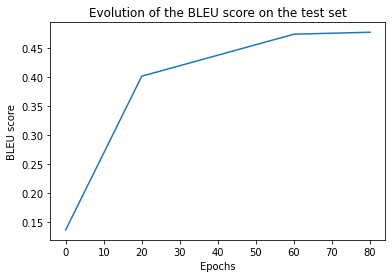

In [99]:
plt.plot(checkpoints, test_score)
plt.title('Evolution of the BLEU score on the test set')
plt.xlabel('Epochs')
plt.ylabel('BLEU score')
plt.show()

In [114]:
%%time
img_path = '/data/val/'
img_train = merged_df['file_name'].unique()
checkpoints = [0, 20, 60, 80]
train_score = []

## we calculate the average blue score on the test for all the saved training checkpoints
for epoch in checkpoints:

    model.load_state_dict(torch.load(f'attention_model_state_ep{epoch}.pth'))
    blue_score_avg = 0

    for img in tqdm(img_train):
      im = Image.open(img_path + 	img).convert("RGB")
      target_captions = merged_df[merged_df['file_name']==img]
      caps,alphas = get_caps_from(transform_test(im).unsqueeze(0), show=False)
      pred_caption = ' '.join(caps[:-1])  # remove the <EOS>

      blue_score = bleu_score.sentence_bleu(references= target_captions['caption'].values,
                                      hypothesis = pred_caption)
      blue_score_avg += blue_score

    blue_score_avg /= len(img_train)
    train_score.append(blue_score_avg)

100%|██████████| 5008/5008 [07:17<00:00, 11.43it/s]

CPU times: user 29min 45s, sys: 22.3 s, total: 30min 7s
Wall time: 29min 52s


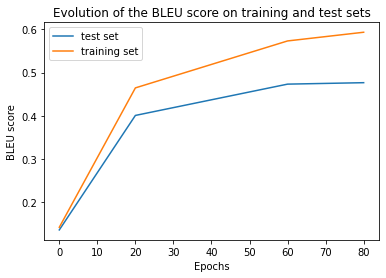

In [117]:
plt.plot(checkpoints, test_score, label='test set')
plt.plot(checkpoints, train_score, label='training set')
plt.title('Evolution of the BLEU score on training and test sets')
plt.xlabel('Epochs')
plt.ylabel('BLEU score')
plt.legend()
plt.show()